In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def carregar_dados(caminho):
    colunas = ["_RAJ2000 (h:m:s)", "_DEJ2000 (d:m:s)", "Num", "CGCG", "NGC_IC", "UGC", "cz (km/s)", 
               "RA1950 (h:m:s)", "DE1950 (d:m:s)", "B25.5(mag)", "SB25.5(mag)", "5 (arcsec)", "pe", 
               "_RA.icrs (h:m:s)", "_DE.icrs (d:m:s)"]
    
    dataset = pd.read_csv(caminho, header=None, comment='#', names=colunas, sep='|', usecols=range(1, len(colunas) + 1))
    dataset['cz (km/s)'] = dataset['cz (km/s)'].str.strip().replace('', '0').astype(float)
    return dataset[dataset['cz (km/s)'] != 0]

In [3]:
def filtrar_galaxias(dataset, v_aglomerado=6925, dispersao=1000):
    limite_inf, limite_sup = v_aglomerado - 2 * dispersao, v_aglomerado + 2 * dispersao
    return dataset[(dataset['cz (km/s)'] >= limite_inf) & (dataset['cz (km/s)'] <= limite_sup)]

In [4]:
def converter_ra_dec(ra, dec):
    def ra_to_deg(ra):
        h, m, s = map(float, ra.split())
        return (h + m / 60 + s / 3600) * 15
    
    def dec_to_deg(dec):
        d, m, s = map(float, dec.split())
        sinal = -1 if d < 0 else 1
        return sinal * (abs(d) + m / 60 + s / 3600)
    
    return ra.apply(ra_to_deg).values, dec.apply(dec_to_deg).values

In [5]:
def angular_distance(ra1, dec1, ra2, dec2):
    ra1, dec1, ra2, dec2 = map(np.radians, [ra1, dec1, ra2, dec2])
    delta_ra = ra2 - ra1
    delta_dec = dec2 - dec1
    a = np.sin(delta_dec / 2)**2 + np.cos(dec1) * np.cos(dec2) * np.sin(delta_ra / 2)**2
    return 2 * np.arcsin(np.sqrt(a)) * (180 / np.pi)

In [6]:
def plotar_histograma(dataset, intervalo=250):
    plt.figure(figsize=(6, 4))
    plt.hist(dataset['cz (km/s)'], bins=np.arange(dataset['cz (km/s)'].min(), dataset['cz (km/s)'].max() + intervalo, intervalo))
    plt.xlabel('cz (km/s)')
    plt.ylabel('Frequência')
    plt.title('Histograma de cz (km/s)')
    plt.show()

In [7]:
def plotar_mapa_galaxias(galaxias_e, galaxias_l, centro_ra, centro_dec):
    ra_e, dec_e = converter_ra_dec(galaxias_e['_RAJ2000 (h:m:s)'], galaxias_e['_DEJ2000 (d:m:s)'])
    ra_l, dec_l = converter_ra_dec(galaxias_l['_RAJ2000 (h:m:s)'], galaxias_l['_DEJ2000 (d:m:s)'])
    
    plt.figure(figsize=(8, 6))
    plt.scatter(ra_e, dec_e, marker='*', s=30, color='orange', label='Galáxias Early-Type')
    plt.scatter(ra_l, dec_l, marker='+', s=30, color='purple', label='Galáxias Late-Type')
    plt.scatter(centro_ra, centro_dec, marker='o', s=50, color='black', label='Centro do Aglomerado')
    plt.xlabel('RA (graus)')
    plt.ylabel('DEC (graus)')
    plt.title('Posições das galáxias do aglomerado de Coma')
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.show()

In [8]:
def plotar_histograma_fracoes(galaxias_e, galaxias_l, ra_centro_deg, dec_centro_deg):
    ra_e, dec_e = converter_ra_dec(galaxias_e['_RAJ2000 (h:m:s)'], galaxias_e['_DEJ2000 (d:m:s)'])
    ra_l, dec_l = converter_ra_dec(galaxias_l['_RAJ2000 (h:m:s)'], galaxias_l['_DEJ2000 (d:m:s)'])
    
    distancias_e = angular_distance(ra_e, dec_e, ra_centro_deg, dec_centro_deg)
    distancias_l = angular_distance(ra_l, dec_l, ra_centro_deg, dec_centro_deg)
    
    dist_e = np.radians(distancias_e) * 99
    dist_l = np.radians(distancias_l) * 99
    
    intervalos = np.linspace(min(dist_e.min(), dist_l.min()), max(dist_e.max(), dist_l.max()), num=9)
    
    hist_e, _ = np.histogram(dist_e, bins=intervalos)
    hist_l, _ = np.histogram(dist_l, bins=intervalos)
    
    total_por_bin = hist_e + hist_l
    frac_e = hist_e / total_por_bin
    frac_l = hist_l / total_por_bin
    
    plt.figure(figsize=(8, 6))
    plt.bar(intervalos[:-1], frac_e, width=0.7, color='purple', alpha=0.8, label='Fração de Galáxias Early-Type', align='edge')
    plt.bar(intervalos[:-1], frac_l, width=0.7, color='orange', alpha=0.8, bottom=frac_e, label='Fração de Galáxias Late-Type', align='edge')
    plt.xlabel('Distância (Mpc)')
    plt.ylabel('Fração de galáxias')
    plt.legend(loc='lower left')
    plt.xticks(intervalos.round(2))
    plt.show()

## Carregar os dados

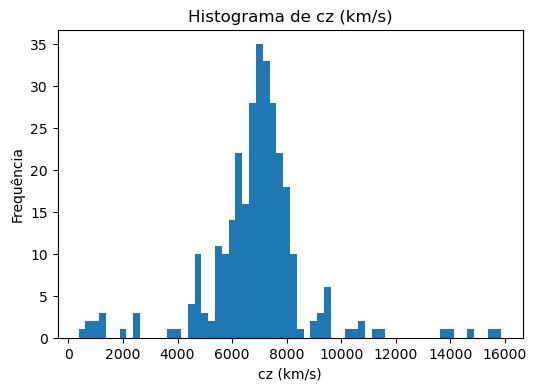

In [9]:
dataset = carregar_dados("./MODIFICADOCatalogComaCluster.txt")
plotar_histograma(dataset)

## Filtrar galáxias

In [10]:
galaxias_filtradas = filtrar_galaxias(dataset)
galaxias_e = galaxias_filtradas[galaxias_filtradas['pe'] == 'E']
galaxias_l = galaxias_filtradas[galaxias_filtradas['pe'] == 'L']

## Definindo o centro do aglomerado

In [11]:
ra_centro, dec_centro = converter_ra_dec(pd.Series(['12 59 48.7']), pd.Series(['+27 58 50']))

## Mapa das galáxias no aglomerado Coma

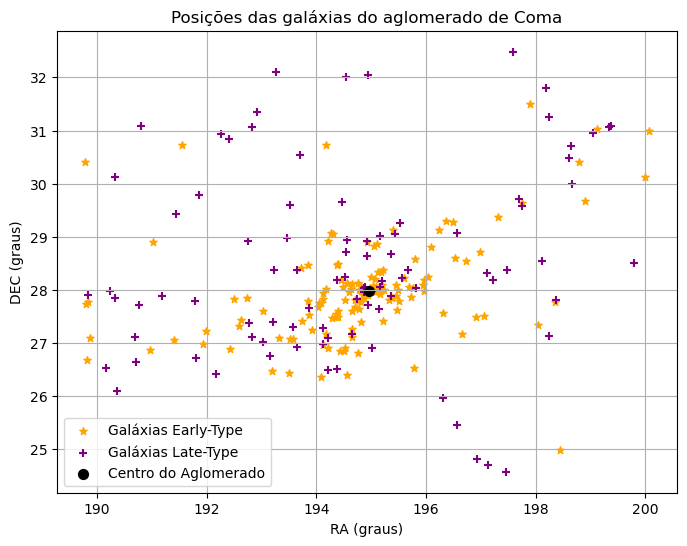

In [12]:
plotar_mapa_galaxias(galaxias_e, galaxias_l, ra_centro[0], dec_centro[0])

## Fração de galáxias para cada bin de distância

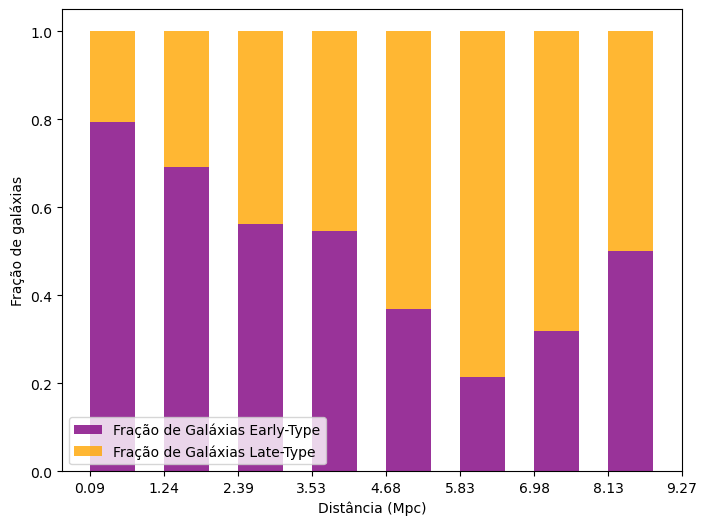

In [13]:
plotar_histograma_fracoes(galaxias_e, galaxias_l, ra_centro[0], dec_centro[0])